# Tutorial on how to solve POMDP

This is a tutorial on how to solve a POMDP in python with [PERSEUS solver](https://arxiv.org/pdf/1109.2145.pdf) . It is tested on the tiger problem

### Intuition behind POMDP

- The state set represents all the possible underlying states the process can be in, though this state is not directly observable.
- The action set is all the available control choices at each point in time.
- The observation set consists of all the possible observations that the process can emit. The state transition function encodes the uncertainty in the process state evolution, while the observation function relates the process outputs (observations) to the true underlying state of the process.
- Finally, the reward function gives the immediate utility for performing an action in each of the underlying process states.

### Formal Definition

A Partially Observable Markov Decision Process (POMDP) is a tuple  $(S, A, T, R, \gamma, {\cal O} , \Omega)$ where: 

- $S$ is the set of possible states for the system
- $A$ is the set of possible actions
- $T$: $S\times A \times S \mapsto [0,1]$ corresponds the system dynamics and is reprensented by $P(s' | s, a)$
- $R$: $S \times A \mapsto \mathbb{R}$ is the reward function
- $\Omega$ is a set of observations
- $O$: $\Omega \times S \times A \mapsto [0,1] $ corresponds to the dynamics of what can be observed to the agent and can be represented by $P(o|s',a)$ 


The <span style="color:red">belief</span> $\textbf{b}_0$ represents the probability distribution over states in the first iteration. In the iteration at $t$, the belief is defined by :  $ \textbf{b}_t(s) = P(s_t = s| o_t , a_{t-1}, ... , a_0 )$, but can be approximated by $b_o^a(s') =\frac{p(o|s',a) }{p(o|\textbf{b},a)}\sum_s p(s'|s,a)b(s) $ if $o$ was the last received observation and $a$ the action that led to this observation. 


### Usage

We want to use this model to derive a control $\textit{policy}$ denoted $\pi : B \mapsto A$ that will yield the greatest amount of utility over some number of decision steps. 

This model can be used as suggested in [A Survey of POMDP Applications](http://www.pomdp.org/papers/applications.pdf) for:
- Machine maintenance policy 
- Structural inspection policy 
- Elevator control policies
- ...
- Medical diagnosis
- Health Care Policymaking


Algorithms using (PO)MDP are a subfield of artificial intelligence.

## Toy example: Tiger problem

Let's consider a simple example, the famous "Tiger Problem" used in POMDP.

 A tiger is put with equal probability behind one of two doors, while treasure is put behind the other one. You are standing in front of the two closed doors and need to decide which one to open. If you open the door with the tiger, you will get hurt by the tiger (negative reward), but if you open the door with the treasure, you receive a positive reward. Instead of opening a door right away, you also have the option to wait and listen for tiger noises. But listening is neither free nor entirely accurate. You might hear the tiger behind the left door while it is actually behind the right door and vice versa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [16]:
prob_right = 0.5
prob_obs = 0.85

states = ['tiger_left','tiger_right']
actions = ['listen','open_left', 'open_right']
observations = ['noise_left','noise_right']
T_a1 = pd.DataFrame({states[0]:[1-prob_right,1-prob_right] , states[1]:[prob_right,prob_right]},index = states)
T_a2 = T_a1
O_a1 = pd.DataFrame({observations[0]:[1-prob_right,1-prob_right] , observations[1]:[prob_right,prob_right]},index = states)
O_a2 = O_a1
T_a0 = pd.DataFrame({states[0]:[1,0] , states[1]:[0,1]},index = states)
O_a0 = pd.DataFrame({observations[0]:[prob_obs,1-prob_obs] , observations[1]:[1-prob_obs,prob_obs]},index = states)

R = pd.DataFrame({actions[0]:[-1, -1],actions[1]:[-100 , 10],actions[2]:[10, -100]},index = states)
O = {actions[0]:O_a0, actions[1]:O_a1,  actions[2]:O_a2}
T = {actions[0]:T_a0, actions[1]:T_a1,  actions[2]:T_a2}

In [17]:
R

,listen,open_left,open_right
tiger_left,-1,-100,10
tiger_right,-1,10,-100


## Solving with Perseus:

Perseus is a randomized point-based solver for POMDP that focuses on the notion of value $V$.

The value of a given policy $\pi$ is defined as 
- $V_{\pi} = E_{\pi} [\sum_t \gamma^t r(b_t ,\pi(b_t)) | b_0 =b]$ where $r(b_t ,\pi(b_t)) = \sum_s r(s ,\pi(b_t))b_t(s)$

But it can be approximated by a PWLC function of vectors $\{{\alpha}_i^n\}_{i}$ at stage $n$ of optimization
-  $V_n(b) = max_{\{{\alpha}_i^n\}_{i}}b.\alpha_i^n$

We want to find the optimum value function $V(b)^*$ for every belief to yield optimal actions

First we have to initialize some variables such as the first alpha vectors and the value function (of the belief):
- $\alpha_0$ = $\frac{1}{1-\gamma}min_{s \in S , a \in A}R(s,a)$

In [18]:
gamma = 0.95
alpha0 = (1/(1-gamma))*np.min(R.values)
V_0 = [([alpha0 for ii in range(len(states))],action) for action in actions ]

Initially, the belief of being in any state is random. 

Suppose that we receive an observation $o$ after taking an action $a$. Then we can update the belief of our state $s'$: $b_o^a(s') =\frac{p(o|s',a) }{p(o|\textbf{b},a)}\sum_s p(s'|s,a)b(s) $

In [27]:
# This function returns the belief for every state
b0 = pd.DataFrame([0.5,0.5],index = states)
def update_belief(current_belief,observation,action):
    b1_not_normed = []
    for s_prime in states:
        p_o_s_prime_a = O[action][observation][s_prime] # float
        sum_p_sprime_s_a = T[action][s_prime].dot(current_belief)
        b1_not_normed.append(p_o_s_prime_a*sum_p_sprime_s_a)
    next_belief = b1_not_normed/np.sum(b1_not_normed)
    return pd.DataFrame(next_belief,index = states) 

One important step when using Perseus is to build a set of reachable beliefs. To do so we simply simulate random policy starting from different states and record reached beliefs:

In [31]:
def expand_belief(b0,N,M):
    beliefs = [b0]
    for i in range(M):
        state = states[np.argmax(np.random.multinomial(1,[b0.values[i][0] for i in range(len(b0))],size= 1))]
        belief = b0
        for i in range(N):     
            action = actions[np.random.randint(0,3)]
            next_state = states[np.argmax(np.random.multinomial(1,T[action].T[state].values,size= 1))]
            observation = observations[np.argmax(np.random.multinomial(1,O[action].T[next_state].values,size = 1))]
            next_belief = update_belief(belief, observation, action)
            state = next_state
            belief = next_belief
            if True not in [belief.equals(bb) for bb in beliefs]:
                beliefs.append(belief)
    return beliefs

In [32]:
beliefs = expand_belief(b0,100,50)

We also need to compute the backup given any belief point:

- $\alpha = backup(\textbf{b})= arg \max_{ \{ g^b_a \}_{a \in A} } \textbf{b}. \textbf{g}^b_a$ which has the dimension of S
- With $\textbf{g}^b_a = r_a + \gamma \sum_o argmax_{\{\textbf{g}^i_{a,o}\}_i} \textbf{b}.\textbf{g}^i_{a,o}$ of dimension S
- And $g^i_{a,o}(s) = \sum_{s'} p(o|s',a)p(s'|s,a)\alpha^i_n(s')$


In [33]:
#Starting with the last point, we compute the compute_g_a_o_i_s
def compute_g_a_o_i_s(alpha_vector,observation,state,action):
    seum = []
    for state_prime in range(len(states)):
        seum.append(O[action].T[states[state_prime]][observation] * T[action].T[state][states[state_prime]] * alpha_vector[0][state_prime])
    g_a_o_i_s = sum(seum)
    return g_a_o_i_s

#Then we compute g_a_b:
def compute_g_ab( belief ,V_n,action):
    argmax_o_l = []
    for o in observations:
        
    # For all alpha vectors alpha_i, we compute g_a_o_i (of dimension S)
        list_gao_b = []
        list_gao = []

        for alpha_vector in V_n:
            list_inter = []
            for sss in states:
                g_a_o_i_s  = compute_g_a_o_i_s(alpha_vector, o, sss,action)
                list_inter.append(g_a_o_i_s)
            g_a_o_i = pd.DataFrame(list_inter,index = states) 
            list_gao.append(g_a_o_i)
            list_gao_b.append(g_a_o_i.T.dot(belief).values)
        
        best_gaoi = list_gao[np.argmax(list_gao_b)]
        argmax_o_l.append(best_gaoi) 
    g_ab = R[action] + gamma*sum(argmax_o_l)[0]
    
    return g_ab 
            
#We finally exploit the belief: 
def backup(belief,V_n):
    b_g_ab_list = []
    g_ab_list = []
    action_list = []
    for action in actions:
        g_ab = compute_g_ab( belief, V_n,action )
        g_ab_list.append(g_ab)
        b_g_ab_list.append(g_ab.dot(belief))
    backup = g_ab_list[np.argmax(b_g_ab_list)]
    act = actions[np.argmax(b_g_ab_list)]
    
    return backup, act

- Now we have all the bricks to perform PERSEUS backup stage $V_{n+1} = \tilde{H}_{Perseus}V_n$ as defined in [the paper](https://arxiv.org/pdf/1109.2145.pdf):

 1) Set $V_{n+1}$ to $\emptyset$ , initialize $\tilde{B}$ to $B$

 2) Sample a belief point $b$ uniformly at random from $\tilde{B}$ and compute $\alpha = backup(b)$
 
 3) if $b.\alpha > V_{n}(b)$ then add $\alpha$ to $V_{n+1}$, otherwise add $\alpha' = arg max_{\{ \alpha_n^i\}_{i}}b.\alpha_i^n$ to $V_{n+1}$.
 
 4) Compute $\tilde{B} = \{ b \in B : V_{n+1}(b) < V_n(b)\}$
 
 5) If $\tilde{B} = \emptyset$ then stop, else go to 2)


In [34]:
def perseus_backstage(beliefs,V_n):
    compteur = 0
    
    #1
    V_n1 = []
    beliefs_tild = beliefs
    
    #2
    while len(beliefs_tild) != 0:
        belief = random.choice(beliefs_tild)
        alpha_vector, action = backup(belief,V_n)
        
    #3  
        #print(belief.T.dot(alpha_vector).values)
        if belief.T.dot(alpha_vector).values > np.max([np.dot(alpha_i[0],belief ) for alpha_i in  V_n ]):
            V_n1.append([alpha_vector.values,action])
            
        else:
            argmax_list = []
            for vec in [alpha[0] for alpha in V_n ]:
                dot = np.dot(vec,belief)
                argmax_list.append(dot)         
            alpha_prime = V_n[np.argmax(argmax_list)]
            V_n1.append(alpha_prime)
        
    #4
        beliefs_tild = []
        for b in beliefs:
            V_n1_b = np.max([np.dot(alpha_i[0],b) for alpha_i in V_n1])
            V_n_b = np.max([np.dot(alpha_i[0],b) for alpha_i in V_n ])            
            if V_n1_b<V_n_b:
                beliefs_tild.append(b)
        
        # Only for debugging
        compteur = compteur+ 1 
        if compteur > 300:
            break
    return V_n1 

... and we can perform the optimization:

In [36]:
V_n = V_0
for i in range(200):
    V_n1 = perseus_backstage(beliefs,V_n)
    V_n = V_n1

In [37]:
V_n

[[array([-81.71659902,  28.28340098]), 'open_left'],
 [array([24.57628198,  2.89537998]), 'listen'],
 [array([ 2.89537998, 24.57628198]), 'listen'],
 [array([ 28.28340098, -81.71659902]), 'open_right'],
 [array([19.2519694, 19.2519694]), 'listen']]

### Policy evaluation on the tiger problem:

To know if the algorithm converged well, we simulate the policy with the value function and visualize rewards:

In [46]:
# listen
def execute_policy(N,V,b0):
    state = states[np.argmax(np.random.multinomial(1,[b0.values[i][0] for i in range(len(b0))],size= 1))]
    Rew = 0
    winners = 0
    losers = 0
    for i in range(N): 
        action = V[np.argmax([np.dot(alpha_i[0],b0) for alpha_i in V ])][1] 
        next_state = states[np.argmax(np.random.multinomial(1,T[action].T[state].values,size= 1))]
        observation = observations[np.argmax(np.random.multinomial(1,O[action].T[next_state].values,size = 1))] # noise right
        b1 = update_belief(b0,observation,action)
        reward = R[action][state]
        if reward == -100:
            losers +=1
        if reward == 10:
            winners += 1
        state = next_state
        b0 = b1
        #print(state,action,reward,observation)
        #print(reward)
        Rew = Rew+reward
    print('You played with the tiger {} times, You have been eaten {} time(s) and survived {} time(s)'.format(N,losers,winners))
    return Rew

In [47]:
Rew = execute_policy(50,V_n,b0)

You played with the tiger 50 times, You have been eaten 0 time(s) and survived 12 time(s)


It seems good! Thanks for reading

The approach is generalizable to other POMDP problems with resonable state and observation space sizes. 

We can compare the alpha vectors with other ones found with SARSOP or HSVI:

In [48]:
V_sarsop = [[(24.6928 ,3.01186 ),'listen' ],[(3.01202, 24.6924 ),'listen'],[(19.3687 ,19.3683),'listen'],[(-81.6 ,28.4),'open_left'],[(28.3998 ,-81.6002),'open_right']]
V_sarsop

[[(24.6928, 3.01186), 'listen'],
 [(3.01202, 24.6924), 'listen'],
 [(19.3687, 19.3683), 'listen'],
 [(-81.6, 28.4), 'open_left'],
 [(28.3998, -81.6002), 'open_right']]

### Classical illustration : 

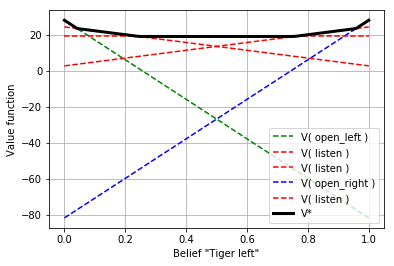

In [49]:
def plot_Vn(V_n):
    max_value = []
    for alpha_vec in V_n:
        intercept = np.dot(alpha_vec[0],[0,1])
        slope = np.dot(alpha_vec[0],[1,0]) - intercept
        x = np.linspace(0,1,100)
        y = slope*x + intercept
        max_value.append(y)
        if alpha_vec[1] == 'listen':
            col = '--r'
        if alpha_vec[1] == 'open_right':
            col = '--b'
        if alpha_vec[1] == 'open_left':
            col = '--g'
        
        plt.plot(x,y,col,label = 'V( '+alpha_vec[1]+' )')
    plt.xlabel('Belief "Tiger left"')
    plt.ylabel('Value function')
    plt.plot(x,np.maximum.reduce(max_value),'k',linewidth=3.0,label = 'V*')
    plt.legend(loc = 'lower right')
    plt.grid()
    plt.show()
    
plot_Vn(V_n)